In [66]:
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Firstly, Get the stock codes from https://bullishbears.com/dow-jones-stocks-list/

In [28]:
def fetch_stock_codes(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')

    stock_codes = []

    # Find the table with stock data
    stock_table = soup.find('table', {'id': 'tablepress-37'})

    if stock_table:
        # Find all the rows in the table
        rows = stock_table.find_all('tr')

        # Iterate through each row
        for row in rows:
            # Find all the cells in the row
            cells = row.find_all('td')

            # Extract stock code 
            if len(cells) >= 2:
                stock_code = cells[0].get_text().strip()
                stock_codes.append(stock_code)

    return stock_codes

In [29]:
def download_stock_returns(stock_codes, start_date, end_date):
    stock_returns = {}

    for stock_code in stock_codes:
        ticker = yf.Ticker(stock_code)
        historical_data = ticker.history(start=start_date, end=end_date, interval="1d")

        if not historical_data.empty:
            returns = historical_data['Close'].pct_change().dropna()
            stock_returns[stock_code] = returns

    return stock_returns

In [30]:
url = "https://bullishbears.com/dow-jones-stocks-list/"
stock_codes = fetch_stock_codes(url)

print(f"Stock codes found: {len(stock_codes)}")
print(stock_codes)

Stock codes found: 30
['AAPL', 'MSFT', 'UNH', 'V', 'JNJ', 'WMT', 'JPM', 'PG', 'HD', 'CVX', 'KO', 'DIS', 'CSCO', 'VZ', 'NKE', 'MRK', 'INTC', 'CRM', 'MCD', 'AXP', 'AMGN', 'HON', 'CAT', 'IBM', 'GS', 'BA', 'MMM', 'DOW', 'TRV', 'WBA']


In [31]:
start_date = '2010-01-01'
end_date = '2022-12-31'

stock_returns = download_stock_returns(stock_codes, start_date, end_date)

In [33]:
# Combine the stock returns into a single DataFrame
stock_returns_df = pd.concat(stock_returns, axis=1)

# Save the stock returns to a CSV file
stock_returns_df.to_csv("stock_returns_2010_2022.csv")

print(f"Stock returns downloaded for {len(stock_returns)} stocks.")

Stock returns downloaded for 30 stocks.


Part I

Question 1:

In [77]:
# Read the data from the CSV file
data = pd.read_csv('stock_returns_2010_2022.csv', index_col='Date')
data.index = pd.to_datetime(data.index, utc=True).tz_convert(None)
data.index = data.index.normalize()
data.head()

,AAPL,MSFT,UNH,V,JNJ,WMT,JPM,PG,HD,CVX,...,AMGN,HON,CAT,IBM,GS,BA,MMM,DOW,TRV,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.001729,0.000323,-0.001586,-0.011459,-0.011596,-0.009958,0.019370,0.000327,0.007325,0.007084,...,-0.008663,0.001983,0.011956,-0.012080,0.017679,0.032752,-0.006264,NaN,-0.023690,-0.008043
2010-01-06,-0.015906,-0.006137,0.009848,-0.013429,0.008134,-0.002235,0.005494,-0.004743,-0.003463,0.000125,...,-0.007515,0.000000,0.003038,-0.006496,-0.010673,0.030334,0.014181,NaN,-0.014189,-0.007567
2010-01-07,-0.001849,-0.010400,0.038377,0.009307,-0.007137,0.000560,0.019809,-0.005423,0.011814,-0.003767,...,-0.009156,0.019292,0.004038,-0.003461,0.019569,0.040482,0.000717,NaN,0.014394,0.005991
2010-01-08,0.006648,0.006896,-0.009391,0.002766,0.003438,-0.005037,-0.002456,-0.001322,-0.004808,0.001765,...,0.008885,0.022082,0.011229,0.010035,-0.018911,-0.009646,0.007047,NaN,-0.001439,0.001354
2010-01-11,-0.008822,-0.012720,0.006728,-0.002874,0.000156,0.016501,-0.003357,-0.003971,-0.028296,0.017743,...,0.004404,0.012583,0.062810,-0.010470,-0.015777,-0.011851,-0.004032,NaN,-0.000412,0.001622


In [78]:
# check the missing data
missing_percentage = data.isna().mean() * 100
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

print(missing_percentage_sorted)

DOW     70.834607
AAPL     0.000000
MSFT     0.000000
TRV      0.000000
MMM      0.000000
BA       0.000000
GS       0.000000
IBM      0.000000
CAT      0.000000
HON      0.000000
AMGN     0.000000
AXP      0.000000
MCD      0.000000
CRM      0.000000
INTC     0.000000
MRK      0.000000
NKE      0.000000
VZ       0.000000
CSCO     0.000000
DIS      0.000000
KO       0.000000
CVX      0.000000
HD       0.000000
PG       0.000000
JPM      0.000000
WMT      0.000000
JNJ      0.000000
V        0.000000
UNH      0.000000
WBA      0.000000
dtype: float64


In [79]:
data = data.drop(columns=['DOW'])
data.head()

,AAPL,MSFT,UNH,V,JNJ,WMT,JPM,PG,HD,CVX,...,AXP,AMGN,HON,CAT,IBM,GS,BA,MMM,TRV,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.001729,0.000323,-0.001586,-0.011459,-0.011596,-0.009958,0.019370,0.000327,0.007325,0.007084,...,-0.002199,-0.008663,0.001983,0.011956,-0.012080,0.017679,0.032752,-0.006264,-0.023690,-0.008043
2010-01-06,-0.015906,-0.006137,0.009848,-0.013429,0.008134,-0.002235,0.005494,-0.004743,-0.003463,0.000125,...,0.016165,-0.007515,0.000000,0.003038,-0.006496,-0.010673,0.030334,0.014181,-0.014189,-0.007567
2010-01-07,-0.001849,-0.010400,0.038377,0.009307,-0.007137,0.000560,0.019809,-0.005423,0.011814,-0.003767,...,0.016218,-0.009156,0.019292,0.004038,-0.003461,0.019569,0.040482,0.000717,0.014394,0.005991
2010-01-08,0.006648,0.006896,-0.009391,0.002766,0.003438,-0.005037,-0.002456,-0.001322,-0.004808,0.001765,...,-0.000714,0.008885,0.022082,0.011229,0.010035,-0.018911,-0.009646,0.007047,-0.001439,0.001354
2010-01-11,-0.008822,-0.012720,0.006728,-0.002874,0.000156,0.016501,-0.003357,-0.003971,-0.028296,0.017743,...,-0.011443,0.004404,0.012583,0.062810,-0.010470,-0.015777,-0.011851,-0.004032,-0.000412,0.001622


In [80]:
# Define a function to calculate portfolio returns
def portfolio_returns(weights, returns):
    return np.dot(weights, returns)

# Define a function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define a function to calculate the Sharpe ratio
def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.0):
    ret = portfolio_returns(weights, returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - risk_free_rate) / vol

# Define a function to optimize the portfolio
def optimize_portfolio(returns, cov_matrix, objective_function, constraints, bounds):
    num_assets = len(returns)
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(
        objective_function,
        initial_weights,
        args=(returns, cov_matrix),
        method='SLSQP',
        constraints=constraints,
        bounds=bounds
    )
    return result.x

In [82]:
# Define constraints and bounds for the optimization
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
)
bounds = [(0, 1) for _ in range(len(data.columns))]

all_gmv_weights = pd.DataFrame(columns=data.columns)
all_sharpe_weights = pd.DataFrame(columns=data.columns)

# Loop through overlapping 3-year windows and optimize the portfolio
start_year = 2010
window_length = 3
end_year = 2022 - window_length + 1

for year in range(start_year, end_year):
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year+window_length}-12-31')
    
    # Create a date range for the interval
    date_range = pd.date_range(start_date, end_date)

    window_data = data[data.index.isin(date_range)]

    # Calculate returns and covariance matrix
    returns = window_data.mean()
    cov_matrix = window_data.cov()

    # Optimize the GMV portfolio
    gmv_weights = optimize_portfolio(
        returns,
        cov_matrix,
        lambda w, r, c: portfolio_volatility(w, c),
        constraints,
        bounds
    )

    # Optimize the max Sharpe portfolio
    max_sharpe_weights = optimize_portfolio(
        returns,
        cov_matrix,
        lambda w, r, c: -sharpe_ratio(w, r, c),
        constraints,
        bounds
    )

    all_gmv_weights.loc[f'{year}-{year+window_length}'] = gmv_weights
    all_sharpe_weights.loc[f'{year}-{year+window_length}'] = max_sharpe_weights

    print(f"\nFor the {year}-{year+window_length} period:")
    print(f"GMV Portfolio Weights: {gmv_weights}")
    print(f"Max Sharpe Portfolio Weights: {max_sharpe_weights}")


For the 2010-2013 period:
GMV Portfolio Weights: [2.16840434e-19 3.98444298e-18 2.71050543e-19 0.00000000e+00
 1.75564986e-01 2.21872330e-01 5.88179679e-18 1.79765580e-01
 0.00000000e+00 0.00000000e+00 9.08110118e-02 2.60208521e-18
 4.25549353e-18 1.09302806e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.74915852e-18 1.94002172e-01 0.00000000e+00
 8.45677695e-18 0.00000000e+00 0.00000000e+00 2.86811143e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.81603864e-18
 3.52365706e-18]
Max Sharpe Portfolio Weights: [1.24585305e-01 0.00000000e+00 1.05597800e-01 6.93210676e-02
 0.00000000e+00 1.70664363e-02 1.23544838e-16 0.00000000e+00
 3.29566635e-01 0.00000000e+00 3.24989601e-17 1.24141149e-17
 0.00000000e+00 1.82698296e-01 6.26994357e-02 0.00000000e+00
 0.00000000e+00 2.49572533e-02 4.13538034e-02 0.00000000e+00
 4.21539684e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.46337670e-17 8.93111540e-18 3.09607483e-17
 0.00000000e+00]

For the 2011-2014 period:
GMV P

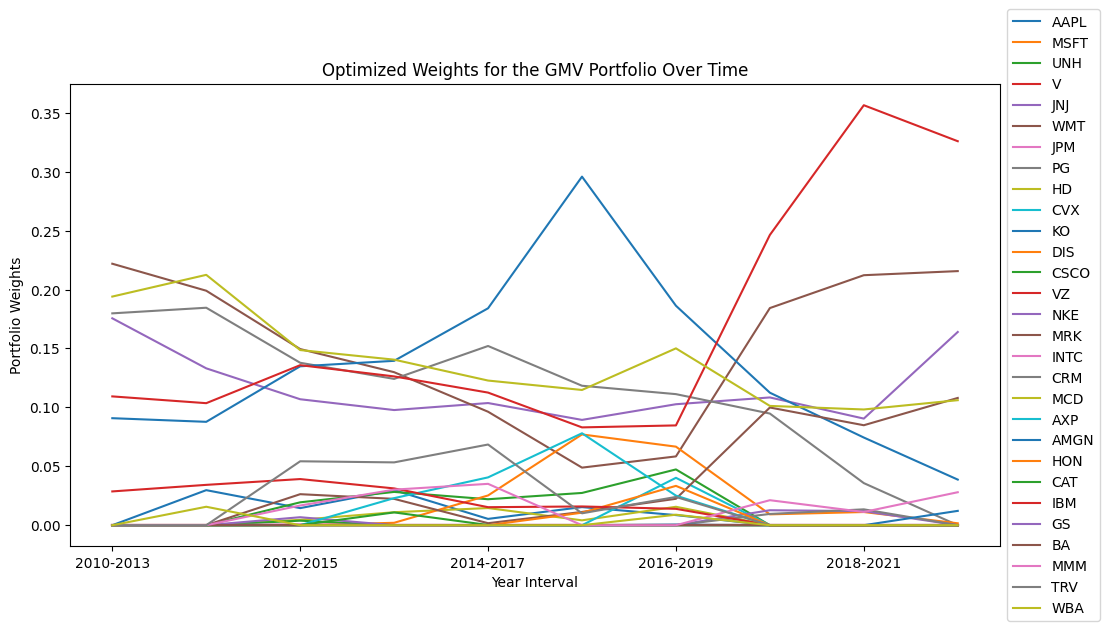

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
all_gmv_weights.plot(ax=ax)
ax.set_xlabel('Year Interval')
ax.set_ylabel('Portfolio Weights')
ax.set_title('Optimized Weights for the GMV Portfolio Over Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

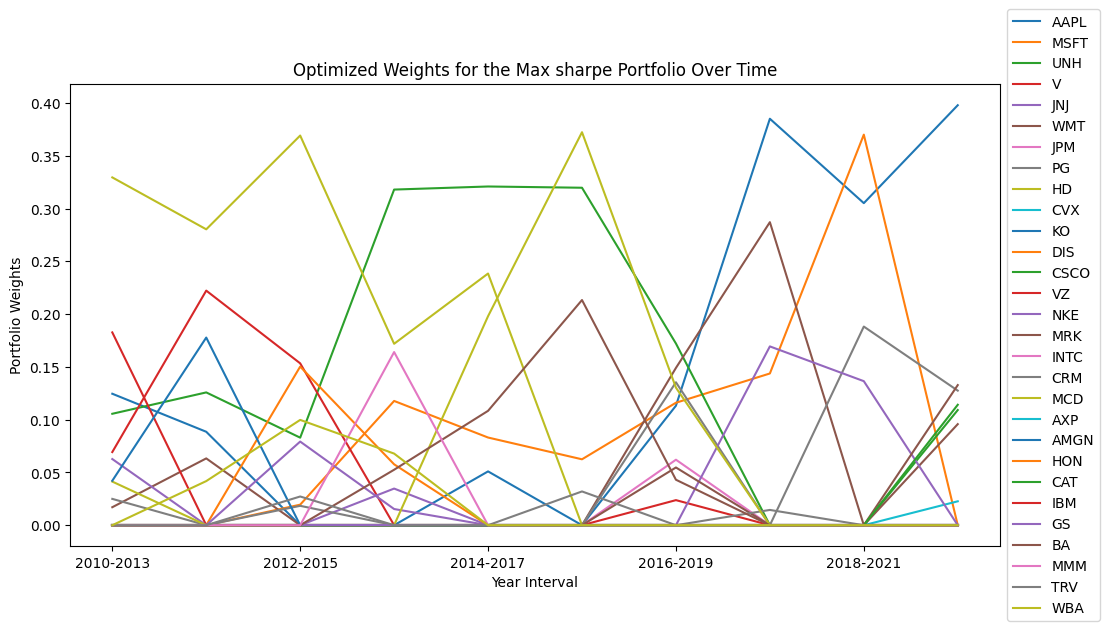

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))
all_sharpe_weights.plot(ax=ax)
ax.set_xlabel('Year Interval')
ax.set_ylabel('Portfolio Weights')
ax.set_title('Optimized Weights for the Max sharpe Portfolio Over Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Question 2

In [73]:
equal_weights = np.ones(data.shape[1]) / data.shape[1]
daily_portfolio_return = data.dot(equal_weights)

# Calculate the annualized return
annualized_return = np.mean(daily_portfolio_return) * 252
print(f'Annualized Return: {annualized_return:.4f}')

# Calculate the VaR (Value at Risk) at the 95% confidence level
VaR_95 = np.percentile(daily_portfolio_return, 5)
print(f'VaR (95%): {VaR_95:.4f}')

# Calculate the Expected Shortfall (ES) at the 95% confidence level
ES_95 = daily_portfolio_return[daily_portfolio_return <= VaR_95].mean()
print(f'Expected Shortfall (95%): {ES_95:.4f}')

Annualized Return: 0.1527
VaR (95%): -0.0164
Expected Shortfall (95%): -0.0258


Question 3

In [83]:
data = pd.read_csv('stock_returns_2010_2022.csv', index_col='Date')
data.index = pd.to_datetime(data.index, utc=True).tz_convert(None)
data.index = data.index.normalize()
data = data.drop(columns=['DOW'])

In [89]:
def check_sum(weights):
    return np.sum(weights) - 1

def portfolio_vol(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def optimize_gmv(data):
    cov_matrix = data.cov()
    num_assets = data.shape[1]
    init_guess = np.array([1.0 / num_assets] * num_assets)
    
    # Define the constraints
    weights_sum_to_1 = {'type': 'eq', 'fun': check_sum}
    bounds = [(0, 1)] * num_assets

    # Optimize the portfolio
    optimized_result = minimize(portfolio_vol, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=weights_sum_to_1)
    
    # Return the optimized weights
    return optimized_result.x


In [90]:
portfolio_returns = pd.DataFrame(columns=['Invested_GMV', 'Actual_GMV'])


for year in range(start_year, end_year):
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year+window_length}-12-31')
    
    # Create a date range for the interval
    date_range = pd.date_range(start_date, end_date)

    window_data = data[data.index.isin(date_range)]

    # Calculate returns and covariance matrix
    returns = window_data.mean()
    cov_matrix = window_data.cov()

    # Optimize the GMV portfolio
    gmv_weights = optimize_portfolio(
        returns,
        cov_matrix,
        lambda w, r, c: portfolio_volatility(w, c),
        constraints,
        bounds
    )

    # Calculate the invested GMV returns over the next 3 years
    next_start_date = pd.Timestamp(f'{year+window_length}-01-01')
    next_end_date = pd.Timestamp(f'{year+2*window_length}-12-31')
    next_date_range = pd.date_range(next_start_date, next_end_date)
    next_window_data = data[data.index.isin(next_date_range)]
    invested_gmv_returns = next_window_data.dot(gmv_weights)

    # Optimize the actual GMV portfolio using the next 3 years of data
    actual_gmv_weights = optimize_gmv(next_window_data)
    actual_gmv_returns = next_window_data.dot(actual_gmv_weights)

    # Calculate the average annualized returns
    invested_gmv_annualized = np.mean(invested_gmv_returns) * 252
    actual_gmv_annualized = np.mean(actual_gmv_returns) * 252

    # Store the annualized returns in the portfolio_returns DataFrame
    portfolio_returns.loc[f'{year+window_length}-{year+2*window_length}'] = [invested_gmv_annualized, actual_gmv_annualized]

In [91]:
print(portfolio_returns)

           Invested_GMV  Actual_GMV
2013-2016      0.098799    0.113330
2014-2017      0.113907    0.111129
2015-2018      0.097926    0.092317
2016-2019      0.152878    0.147023
2017-2020      0.153673    0.153144
2018-2021      0.146571    0.113374
2019-2022      0.136361    0.084798
2020-2023      0.066493    0.047632
2021-2024      0.006026    0.096862
2022-2025      0.000026    0.153464


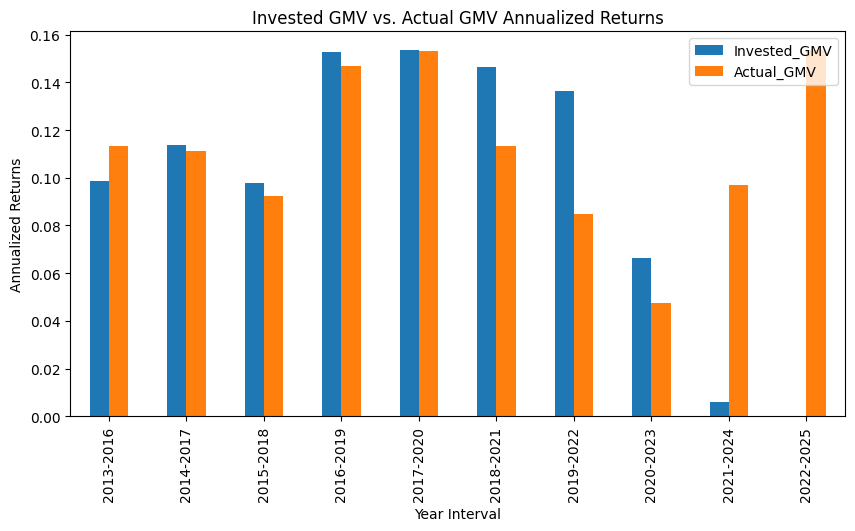

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))
portfolio_returns.plot(kind='bar', ax=ax)
ax.set_xlabel('Year Interval')
ax.set_ylabel('Annualized Returns')
ax.set_title('Invested GMV vs. Actual GMV Annualized Returns')
ax.legend(loc='upper right')

plt.xticks(range(len(portfolio_returns.index)), portfolio_returns.index)
plt.show()